# Overview of the evaluation module


This notebook demonstrates the evaluation of three debiasers, ISIMIP (Lange 2021), CDFt (Vrac 2017) and Quantile Delta Mapping (Cannon et al 2015) to the variables tas (daily mean 2m surface temperature, K) and pr (total daily precipitation flux, kg/m2/s). ISIMIP is additionally applied to tasmin (daily minimum 2m surface temperature, K) and tasmax (daily maximum 2m surface temperature, K).

The evaluation module provides a set of functionalities that can help you assess the performance of your bias correction method. The notebook is structured along the following three components of the module:

- **Testing assumptions of different debiasers**: Different debiasers rely on different assumptions - some are parametrics, others non-parametric, some bias correct each day of the year separately, others are applied to all days of the year in the same way. This components is meant to check some of these assumptions and help the user rule out the use of some debiasers that are not fit for purpose in this specific application.
- **Evaluating the bias corrected model on a validation period**: In order to assess the performance of a bias correction method, the bias corrected model data should be compared to observational / reanalysis data. This component provides insight into the correction of marginal biases, as well as temporal, spatial and spatiotemporal metrics.
- **Investigating whether the climate change trend is preserved**: Bias correction methods can significantly modify the trend projected in the climate model simulation (Switanek 2017). Have a look at the documentation of individual debiasers to see whether the method is explicitely trend-preserving or not. This component shows the bias in trend of different metrics between the raw and bias corrected climate model.

## Set-up and data pre-processing

This step requires you to have downloaded and preprocessed observational or reanalysis data (such as ERA5) as well as simulations of a climate model during a historical and future (or application) period. Necessary pre-processing steps include regridding the datasets to the same area and grid in space and time and conducted checks for corrupted or missing data.

For the purpose of this demonstration, we will work with the testing data uploaded to the github folder of ibicus. This data is already preprocessed and numpy arrays of data have been extracted. We can get it using: 

```
!wget https://github.com/esowc/ibicus/blob/main/notebooks/testing_data.zip -c
!unzip testing_data.zip
```

In [1]:
import numpy as np
import iris
import math

from scipy.stats import norm, laplace, gamma, beta

from ibicus.variables import *
from ibicus.utils import gen_PrecipitationHurdleModel, gen_PrecipitationGammaLeftCensoredModel

from ibicus.debias import ECDFM, ISIMIP, QuantileMapping, DeltaChange, CDFt
from ibicus.debias import QuantileDeltaMapping, ScaledDistributionMapping, LinearScaling

from ibicus.evaluate import assumptions, correlation, marginal, multivariate, trend
from ibicus.evaluate.metrics import *

The second component of the evaluation requires a split of the historical period into training and validation period which is implemented in the following function. As a default value, the split_ratio is set such that the training period ends at the end of a year.

In [2]:
def get_data(variable, path = "testing_data/", split_ratio = 0.7037):
    
    data = np.load(f"{path}{variable}.npz", allow_pickle = True)
    
    cut_off = math.floor(data["obs"].shape[0]*split_ratio)
    
    obs = data["obs"][0:cut_off, :, :]
    obs_validate = data["obs"][cut_off:, :, :]
    cm_hist = data["cm_hist"][0:cut_off, :, :]
    cm_validate = data["cm_hist"][cut_off:, :, :]
    cm_future = data["cm_future"]
    time_obs = data["time_obs"][0:cut_off]
    time_obs_validate = data["time_obs"][cut_off:]
    time_cm_hist = data["time_cm_hist"][0:cut_off]
    time_cm_validate = data["time_cm_hist"][cut_off:]
    time_cm_future = data["time_cm_future"]
    
    return obs, obs_validate, cm_hist, cm_validate, cm_future, time_obs, time_obs_validate, time_cm_hist, time_cm_validate, time_cm_future

Initializing the testing data and dates for tas, pr, tasmin, tasmax:

In [3]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_validate, tas_cm_future, tas_time_obs, tas_time_obs_validate, tas_time_cm_hist, tas_time_cm_validate, tas_time_cm_future = get_data("tas")
tasmin_obs, tasmin_obs_validate, tasmin_cm_hist, tasmin_cm_validate, tasmin_cm_future, tasmin_time_obs, tasmin_time_obs_validate, tasmin_time_cm_hist, tasmin_time_cm_validate, tasmin_time_cm_future = get_data("tasmin")
tasmax_obs, tasmax_obs_validate, tasmax_cm_hist, tasmax_cm_validate, tasmax_cm_future, tasmax_time_obs, tasmax_time_obs_validate, tasmax_time_cm_hist, tasmax_time_cm_validate, tasmax_time_cm_future = get_data("tasmax")
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_validate, pr_cm_future, pr_time_obs, pr_time_obs_validate, pr_time_cm_hist, pr_time_cm_validate, pr_time_cm_future = get_data("pr")

**Calculating tasmin and tasmax**: currently only ISIMIP covers tasmin and tasmax. It also does not bias correct these two variables directly, but rather bias corrects the variables tasrange and tasskew, where 

$$ \text{tasrange} = \text{tasmax} - \text{tasmin} $$

and 

$$ \text{tasskew} = \frac{\text{tas} − \text{tasmin}}{\text{tasrange}} $$

The utils function 'get_tasmin_tasmax' calculates tasmin and tasmax from tasrange and tasskew.

In [4]:
tasrange_obs, tasskew_obs = utils.get_tasrange_tasskew(tas = tas_obs, tasmin = tasmin_obs, tasmax = tasmax_obs)
tasrange_obs_validate, tasskew_obs_validate = utils.get_tasrange_tasskew(tas = tas_obs_validate, tasmin = tasmin_obs_validate, tasmax = tasmax_obs_validate)

tasrange_cm_hist, tasskew_cm_hist = utils.get_tasrange_tasskew(tas = tas_cm_hist, tasmin = tasmin_cm_hist, tasmax = tasmax_cm_hist)
tasrange_cm_validate, tasskew_cm_validate = utils.get_tasrange_tasskew(tas = tas_cm_validate, tasmin = tasmin_cm_validate, tasmax = tasmax_cm_validate)

tasrange_cm_future, tasskew_cm_future = utils.get_tasrange_tasskew(tas = tas_cm_future, tasmin = tasmin_cm_future, tasmax = tasmax_cm_future)

## Part 1: Testing assumptions

Different bias correction methods rely on different assumptions, as described above. A detailed overview of assumptions associated with a specific bias correction method can be found in the documentation of each debiaser. For the sake of demonstration, we investigate the goodness of fit in this notebook:

For all parametric methods, distributions are fitted to the data. Default distributions for each variable are specified in the individual debiasers. We assess the following two components:
- Is the fit of the default distribution 'good enough' or should a different distribution be used? (1)
- Is there any seasonality in the data that should be accounted for, for example by applying a 'running window mode' (meaning that the bias correction is fitted separately for different parts of the year, i.e. windows)? (2)


**Step 1: Calculating the AIC and plottinge the worst fit**

The Akaike Information Criterion is a statistical method for comparative evaluation of different statistical models. The AIC weighs model complexity with goodness of fit, with a lower AIC indicating a 'better model', and is computed as follows: 

$$ AIC = 2 \frac{k}{n} - 2 \frac{l}{n}$$

whereby $l$ is the log likelihood function calculated in the following way:

$$ l = - \frac{n}{2} (1+ \ln(2 \pi) + \ln (\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2)) $$

To demonstrate, we test the fit of the normal and the beta distribution to the temperature data:

In [5]:
tas_obs_aic = assumptions.calculate_aic('tas', tas_obs_validate, scipy.stats.norm, scipy.stats.beta)

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The following boxplot shows the distribution of the AIC across locations for the normal (left) and the beta (right) distribution:

[Text(0.5, 1.0, 'Distribution of AIC values across locations \n Daily mean near-surface air temperature')]

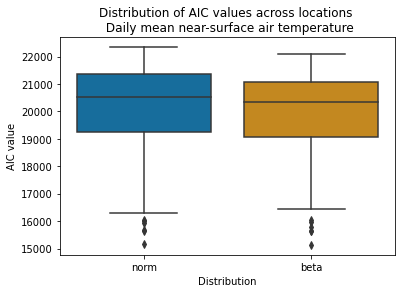

In [6]:
assumptions.plot_aic(variable = 'tas', aic_values = tas_obs_aic)

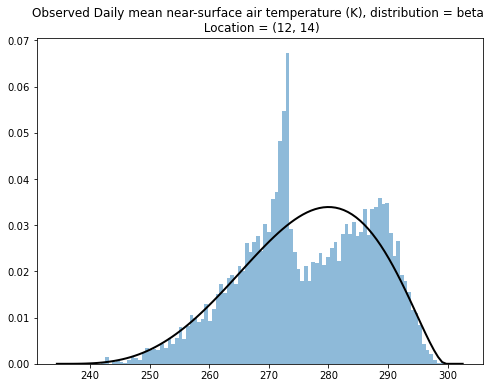

In [7]:
tas_obs_worst_fit = assumptions.plot_fit_worst_aic(variable = 'tas', dataset = tas_obs,  
                                                   data_type = 'Observed', distribution = scipy.stats.beta,
                                                   nr_bins = 100, aic_values = tas_obs_aic)

Given the plot we see above, and the strong bi-modal distribution of the temperature data, we make the assumption that might be seasonal variation at play here. This can be further investigated by using the following function: it plots the time-series and autocorrelation function of the quantile residuals. It also plot a QQ plot of the normalized quantile residuals to get a picture of the goodness of fit for different quantiles. 

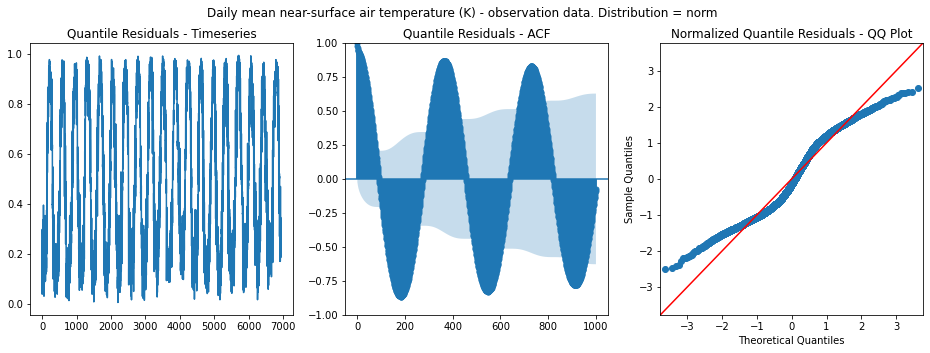

In [8]:
tas_obs_plot_gof = assumptions.plot_quantile_residuals(variable = 'tas', dataset = tas_obs[:,0,0], data_type = 'observation data',
                                                      distribution = scipy.stats.norm)

**Conclusion:**

Overall the distributions do not seem to fit the temperature data too well, mainly due to the bi-modal distribution of temperature. Based on the quantile residuals, we conclude that there is a strong seasonality at play. One option to address this issue would be to build a statistical model that explicitely includes the season as covariate. An alternative approach is to use a so-called 'running-window-mode' (applied for example in the QDM and ISIMIP debiasers) where a separate mapping is conducted each day (or month) of the year, which also takes care of the seasonality. For more details on the running-window-mode, have a look at the documentation of different debiasers.

## Initializing and applying the debiasers

The following section initializes and applies the debiasers ISIMIP, CDFt, Quantile Mapping (QM) and Quantile Delta Mapping (QDM) to the chosen variables. For a more detailed explanaition of the bias correction methods we refer to the documentation, and for some examples on how to customize different debiasers, we refer to the notebook 03 Adjusting Debiasers.

**ISIMIP**

In [9]:
tas_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tas')
tas_val_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate, verbosity='ERRORS_ONLY', parallel=True)
tas_fut_debiased_ISIMIP = tas_debiaser_ISIMIP.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future, verbosity='ERRORS_ONLY', parallel=True)

In [10]:
pr_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'pr')
pr_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_validate, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_validate, verbosity='ERRORS_ONLY', parallel=True)
pr_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(pr_obs, pr_cm_hist, pr_cm_future, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_future, verbosity='ERRORS_ONLY', parallel=True)

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2757: RuntimeWarning: divide by zero encountered in double_scalars
  aest = (3-s + np.sqrt((s-3)**2 + 24*s)) / (12*s)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2756: RuntimeWarning: invalid value encountered in double_scalars
  func = lambda a: np.log(a) - sc.digamma(a) - s
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2756: RuntimeWarning: invalid value encountered in log
  func = lambda a: np.log(a) - sc.digamma(a) - s


/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2757: RuntimeWarning: divide by zero encountered in double_scalars
  aest = (3-s + np.sqrt((s-3)**2 + 24*s)) / (12*s)
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2756: RuntimeWarning: invalid value encountered in double_scalars
  func = lambda a: np.log(a) - sc.digamma(a) - s
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2756: RuntimeWarning: invalid value encountered in log
  func = lambda a: np.log(a) - sc.digamma(a) - s


In [11]:
tasrange_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasrange_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate, verbosity='ERRORS_ONLY', parallel=True)
tasrange_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasrange_obs, tasrange_cm_hist, tasrange_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future, verbosity='ERRORS_ONLY', parallel=True)

In [12]:
tasskew_debiaser_ISIMIP = ISIMIP.from_variable(variable = 'tasrange')
tasskew_val_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate, verbosity='ERRORS_ONLY', parallel=True)
tasskew_fut_debiased_ISIMIP = pr_debiaser_ISIMIP.apply(tasskew_obs, tasskew_cm_hist, tasskew_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future, verbosity='ERRORS_ONLY', parallel=True)

In [13]:
tasmin_val_debiased_ISIMIP, tasmax_val_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_val_debiased_ISIMIP, tasrange = tasrange_val_debiased_ISIMIP, tasskew = tasskew_val_debiased_ISIMIP)
tasmin_fut_debiased_ISIMIP, tasmax_fut_debiased_ISIMIP = utils.get_tasmin_tasmax(tas = tas_fut_debiased_ISIMIP, tasrange = tasrange_fut_debiased_ISIMIP, tasskew = tasskew_fut_debiased_ISIMIP)

**CDFt**

In [14]:
tas_debiaser_CDFT = CDFt.from_variable(variable = 'tas')
tas_val_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate, verbosity='ERRORS_ONLY')
tas_fut_debiased_CDFT = tas_debiaser_CDFT.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future, verbosity='ERRORS_ONLY')

100%|███████████████████████████████████████████| 225/225 [00:34<00:00,  6.48it/s]


In [15]:
pr_debiaser_CDFT = CDFt.from_variable(variable = 'pr')
pr_val_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_validate, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_validate, verbosity='ERRORS_ONLY')
pr_fut_debiased_CDFT = pr_debiaser_CDFT.apply(pr_obs, pr_cm_hist, pr_cm_future, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_future, verbosity='ERRORS_ONLY')

100%|███████████████████████████████████████████| 225/225 [00:34<00:00,  6.54it/s]


**Quantile Delta Mapping**

In [16]:
tas_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "tas")
tas_val_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_validate, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_validate, verbosity='ERRORS_ONLY', parallel=True)
tas_fut_debiased_QDM = tas_debiaser_QDM.apply(tas_obs, tas_cm_hist, tas_cm_future, time_obs = tas_time_obs, time_cm_hist = tas_time_cm_hist, time_cm_future = tas_time_cm_future, verbosity='ERRORS_ONLY', parallel=True)

In [17]:
pr_debiaser_QDM = QuantileDeltaMapping.from_variable(variable = "pr")
pr_val_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_validate, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_validate, verbosity='ERRORS_ONLY', parallel=True)
pr_fut_debiased_QDM = pr_debiaser_QDM.apply(pr_obs, pr_cm_hist, pr_cm_future, time_obs = pr_time_obs, time_cm_hist = pr_time_cm_hist, time_cm_future = pr_time_cm_future, verbosity='ERRORS_ONLY', parallel=True)

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/utils/_math_utils.py:347: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/utils/_math_utils.py:347: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/utils/_math_utils.py:347: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/utils/_math_utils.py:347: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
/Users/fionaspuler/o

**Quantile Mapping**

In [18]:
tas_debiaser_QM = QuantileMapping.from_variable(variable = "tas")
tas_val_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_validate, verbosity='INFO')
tas_fut_debiased_QM = tas_debiaser_QM.apply(tas_obs, tas_cm_hist, tas_cm_future, verbosity='INFO')

pr_debiaser_QM = QuantileMapping.from_variable(variable = "pr")
pr_val_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_validate, verbosity='INFO')
pr_fut_debiased_QM = pr_debiaser_QM.apply(pr_obs, pr_cm_hist, pr_cm_future, verbosity='INFO')

INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|█████████████████████████████████████████| 225/225 [00:00<00:00, 1060.98it/s]
INFO:root:----- Running debiasing for variable: Daily mean near-surface air temperature -----
100%|██████████████████████████████████████████| 225/225 [00:00<00:00, 874.85it/s]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|██████████████████████████████████████████| 225/225 [00:01<00:00, 223.61it/s]
INFO:root:----- Running debiasing for variable: Daily mean precipitation -----
100%|███████████████████████████████████████████| 225/225 [00:02<00:00, 99.52it/s]


## Part 2: Evaluation on validation dataset

### Overview: Statistical Properties and Threshold Metrics

There are essentially two types of analysis that the evaluation module enables you to conduct: one ist an analysis of the statistical properties of the debiased variable - this includes the marginal bias of descriptive statistics such as the mean, or 5th and 95th percentile, as well as the difference in spatial correlation structure. The other is an analysis of threshold metrics. What we mean by the term threshold metrics here, is that specific thresholds are often relevent for impact studies and other applications - for example the number of frost days for crop modelling. Here we can analyse not only the marginal bias, but also the spell length of days of threshold exceedance, or their spatial extent and spatiotemporal cluster size.

The following table gives an overview, which types of analysis are currently available in this release of the package.



|                  | Statistical Properties | Threshold Metrics  |
| ------------     | ---------------------- | -----------------  |
| **Marginal**     | x - marginal bias      | x - marginal bias  |
| **Temporal**     |                        | x - spell length   |
| **Spatial**      | x - RMSE corr matrices | x - spatial extent |
| **Spatioteporal**|                        | x - cluster size   |
| **Multivariate** | x - correlation        |                    |


For each variable, we implemented a number of standard metrics, inspired by the climate extreme indices https://www.climdex.org/learn/indices/

In [19]:
tas_metrics = [warm_days, cold_days]
pr_metrics = [dry_days, wet_days, R10mm, R20mm]
tasmin_metrics = [tropical_nights, frost_days]
tasmax_metrics = [summer_days, icing_days]

Users can have a look at the properties of different threshold metrics:

In [20]:
dry_days

AccumulativeThresholdMetric(threshold_value=1.1574074074074073e-05, threshold_type='lower', name='Dry days \n (< 1 mm/day)', variable='pr')

And edit their properties:

In [21]:
dry_days.threshold_type ="lower"

In addition, the user can define entirely new metrics:

In [22]:
R95p = AccumulativeThresholdMetric(name = '95th percentile \n precipitation', variable = 'pr', 
               threshold_value = np.quantile(np.ndarray.flatten(pr_obs), 0.95), threshold_type = 'higher')

R99p = AccumulativeThresholdMetric(name = '99th percentile \n precipitation', variable = 'pr', 
               threshold_value = np.quantile(np.ndarray.flatten(pr_obs), 0.99), threshold_type = 'higher')

### Marginal Evaluation

We start by investigating the marginal bias of our chosen metrics and descriptive statistics. The user can start with a broader overview plot (see below) and then further investigate that have a particularly large bias, or a particularly large spread across locations, to investigate further.

The plot below shows the distribution of marginal (location-wise) biases across locations. For the mean, this is for example calculated as follows:

$$ \text{Bias}_{ij} = 100 * \frac{\bar{\text{tas}}_{obs, ij} - \bar{\text{tas}}_{cm, ij}}{\bar{\text{tas}}_{obs, ij}} $$

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: divide by zero encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric


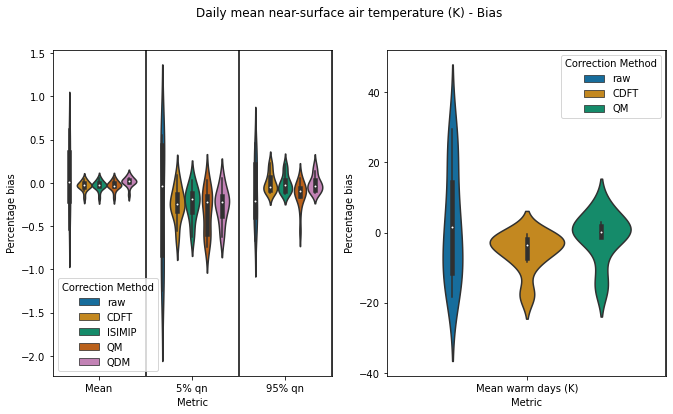

In [24]:
tas_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tas_metrics,
                                                          remove_outliers = True,
                                                          obs_data = tas_obs_validate,
                                                          raw = tas_cm_validate, 
                                                          CDFT = tas_val_debiased_CDFT,
                                                          ISIMIP = tas_val_debiased_ISIMIP,
                                                          QM = tas_val_debiased_QM, QDM = tas_val_debiased_QDM)

tas_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'tas', bias_df = tas_marginal_bias_data)
plt.show()

If remove_outliers is set to True, the function above will not plot distributions that contain inf values, or percentage biases larger than 1000%. Those biases call still be calculated by investigating the dataframe when setting remove_outliers to False.

We can further visually inspect the bias correction of temperature by plotting the associated histogram at one location:

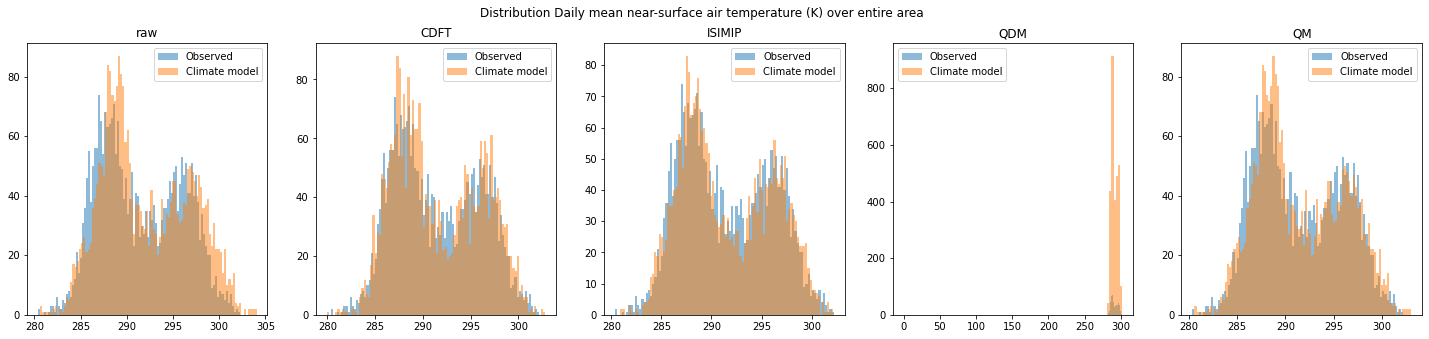

In [25]:
tas_marginal_histograms = marginal.plot_histogram(variable = 'tas', data_obs = tas_obs_validate[:, 0,0],
                                                  raw = tas_cm_validate[:, 0,0], CDFT = tas_val_debiased_CDFT[:, 0,0],
                                                  ISIMIP = tas_val_debiased_ISIMIP[:, 0,0],
                                                  QDM = tas_val_debiased_QDM[:, 0,0],
                                                  QM = tas_val_debiased_QM[:, 0,0])
plt.show()

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: divide by zero encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:26: RuntimeWarning: overflow encountered in true_divide
  mean_bias = 100 * (np.mean(obs_data, axis=0) - np.mean(cm_data, axis=0)) / np.mean(obs_data, axis=0)


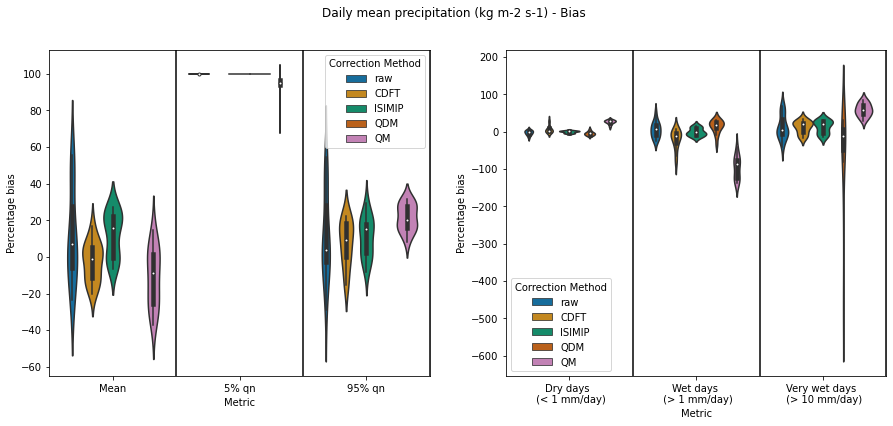

In [26]:
pr_marginal_bias_data = marginal.calculate_marginal_bias(metrics = pr_metrics, obs_data = pr_obs_validate,
                                                         raw = pr_cm_validate, 
                                                         CDFT = pr_val_debiased_CDFT,
                                                         ISIMIP = pr_val_debiased_ISIMIP,
                                                         QDM = pr_val_debiased_QDM,
                                                         QM = pr_val_debiased_QM)

pr_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'pr', bias_df = pr_marginal_bias_data)
plt.show()

For precipitation, the percentage bias of the mean is much larger than for temperature. Also, biases in very high or low percentiles (more extreme values) naturally tend to be larger. It is also advised to interprete percentage bias values with care.

Tasmin and tasmax are currently only bias corrected in ISIMIP:

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: divide by zero encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric


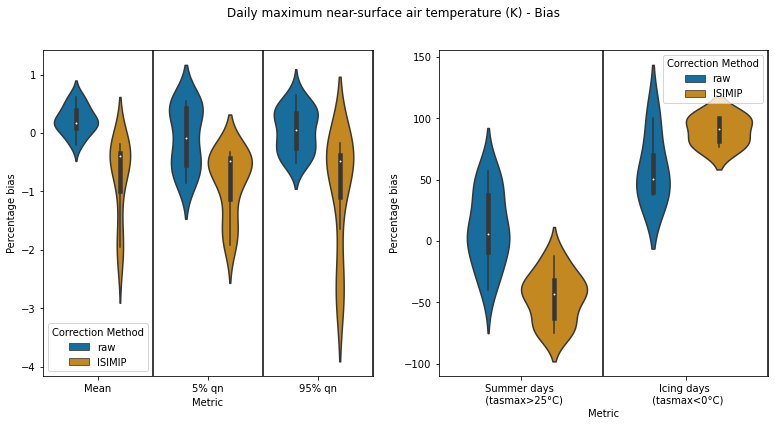

In [27]:
tasmax_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tasmax_metrics,
                                                             remove_outliers = False,
                                                 obs_data = tasmax_obs_validate,
                                                 raw = tasmax_cm_validate, 
                                                 ISIMIP = tasmax_val_debiased_ISIMIP)

tasmax_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'tasmax', bias_df = tasmax_marginal_bias_data)
plt.show()

In this specific application, it seems as though ISIMIP is actually increasing the bias of tasmax (daily maximum near-surface air temperature) compared to the raw climate model. Similarly for tasmin, ISIMIP is not improving the bias.

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: divide by zero encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/marginal.py:54: RuntimeWarning: invalid value encountered in true_divide
  bias = 100 * (obs_metric - cm_metric) / obs_metric


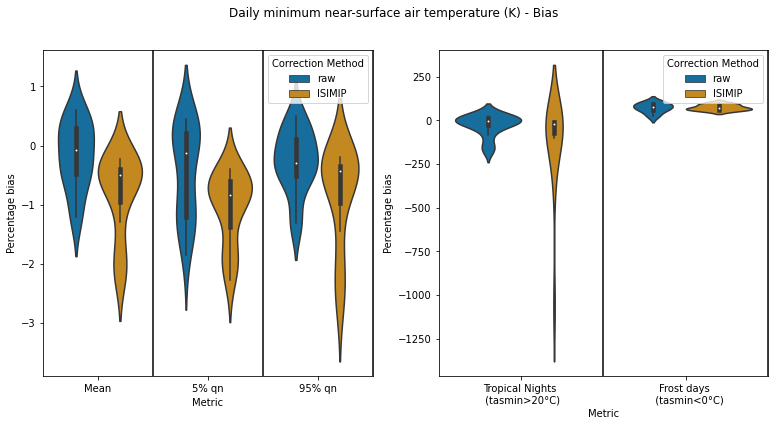

In [28]:
tasmin_marginal_bias_data = marginal.calculate_marginal_bias(metrics = tasmin_metrics,
                                                             remove_outliers = False,
                                                 obs_data = tasmin_obs_validate,
                                                 raw = tasmin_cm_validate, 
                                                 ISIMIP = tasmin_val_debiased_ISIMIP)

tasmax_marginal_bias_plot = marginal.plot_marginal_bias(variable = 'tasmin', bias_df = tasmin_marginal_bias_data)
plt.show()

**Spatial distribution of marginal biases**: The violinplots above can be further investigated by explicetly plotting the spatial distribution of the bias. In the functions below, the user has to choose one metric to investigate further.

Particularly high biases in a certain region could point to deficiencies of the climate model in resolving the topography, or to a mis-placement of a large-scale atmospheric circulation.

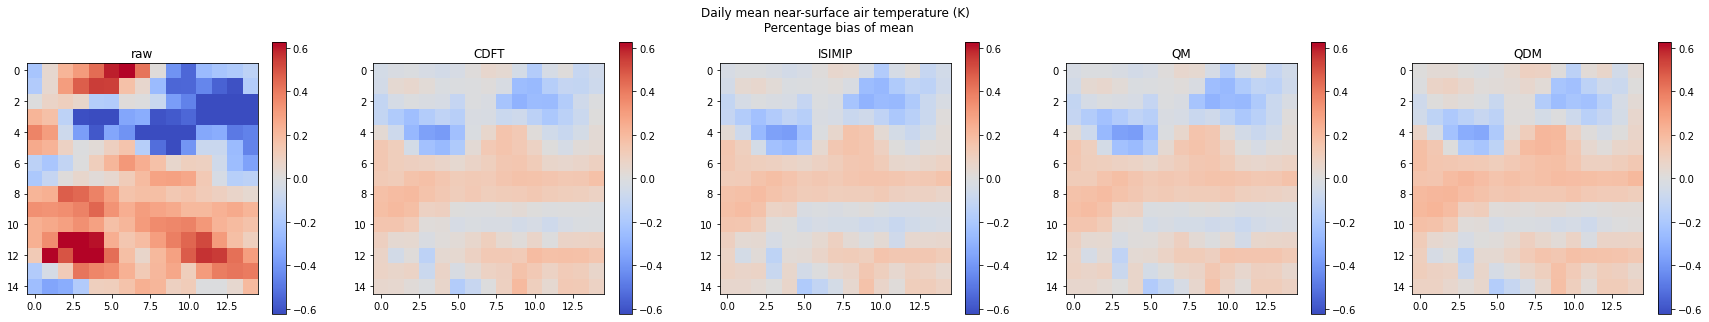

In [29]:
tas_bias_map_mean = marginal.plot_bias_spatial(variable = 'tas', metric = 'Mean', bias_df = tas_marginal_bias_data)

Temperature is overestimated in some regions, and underestimated in others, although the percentage bias even in the raw climate model is quite small. All bias correction method manage to improve the bias of the temperature mean consisten across the area.

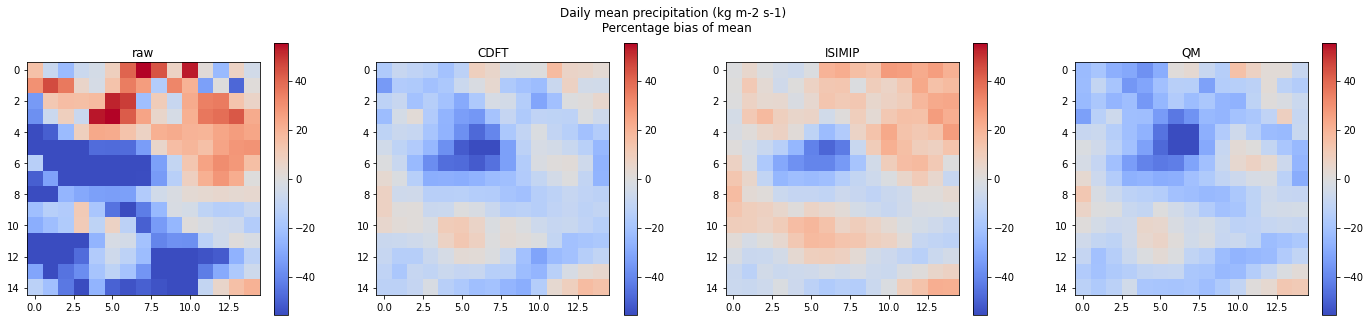

In [30]:
pr_bias_map_mean = marginal.plot_bias_spatial(variable = 'pr', metric = 'Mean', bias_df = pr_marginal_bias_data)

As noted above, precipitation has a higher bias to begin with. Both CDFt and ISIMIP improve the bias overall, but for both there is a region where the bias correction does not seem to working as well and the precipitation mean is underestimated.

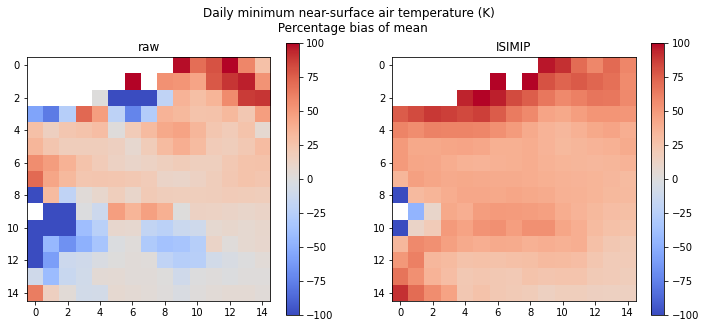

In [31]:
tasmin_bias_map_mean = marginal.plot_bias_spatial(variable = 'tasmin', metric = 'Frost days \n  (tasmin<0°C)', bias_df = tasmin_marginal_bias_data)

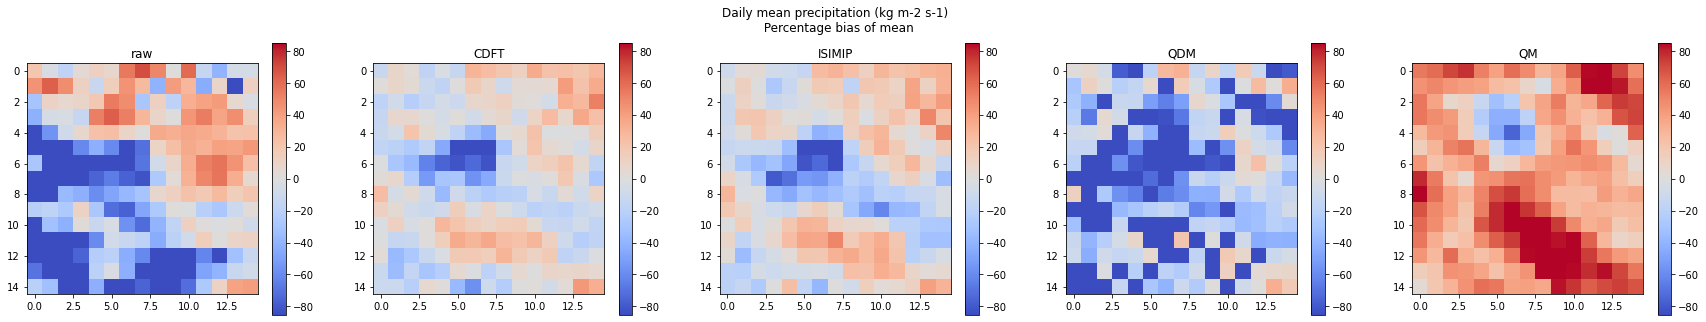

In [32]:
pr_bias_map_extreme = marginal.plot_bias_spatial(variable = 'pr', metric = 'Very wet days \n (> 10 mm/day)', bias_df = pr_marginal_bias_data)

Extreme precipitatino (>20 mm/day) has biases up to 100% in the raw climate model. Both CDFt as well as ISIMIP improve this bias, although CDFt performs slightly better overall. Quantile Delta Mapping and Quantile Mapping fail to improve the bias of extreme precipitation, with QDM significantly underestimating, and QM significantly overestimating it across the entire area.

### Spatial, temporal and spatiotemporal properties 

For each threshold metric, we can calculate the temporal spell length, the spatial extent and the 'spatiotemporal cluster size'.

- Spell length: as the name suggests, we count the number of temporally consecutive threshold exceedances at each location. All numbers below the minimum spell length are kicked out at some point. The plot shows the distribution of spell lengths over the entire area.
- Spatial extent: this metric calculates which percentage of the area is beyond the threshold, given that one location is above the threshold.
- Spatiotemporal clusters: this metrics calculates spatiotemporally connected sets of threshold exceedance across the data.

The plots below show these three distributions for some sample threshold metrics. Each one of them can individually calculated using the bespoke functions.

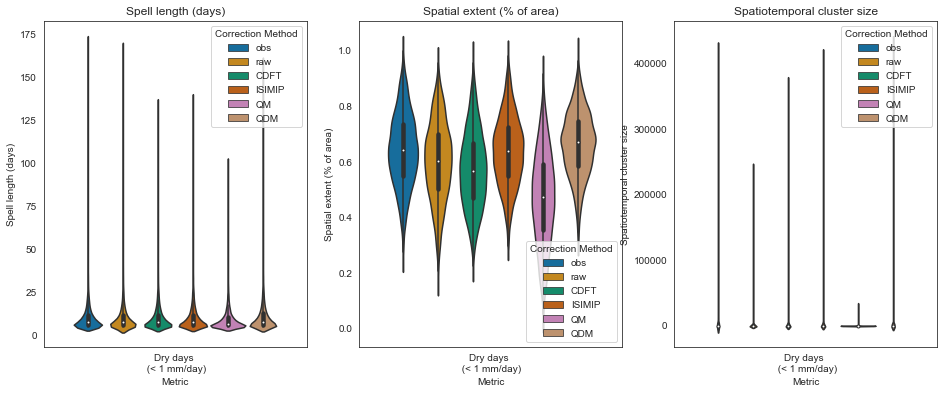

In [48]:
dry_days.violinplots_clusters(minimum_length = 4, obs = pr_obs_validate,
                              raw = pr_cm_validate, CDFT = pr_val_debiased_CDFT,
                              ISIMIP = pr_val_debiased_ISIMIP,
                              QM = pr_val_debiased_QM,
                              QDM = pr_val_debiased_QDM
                              )

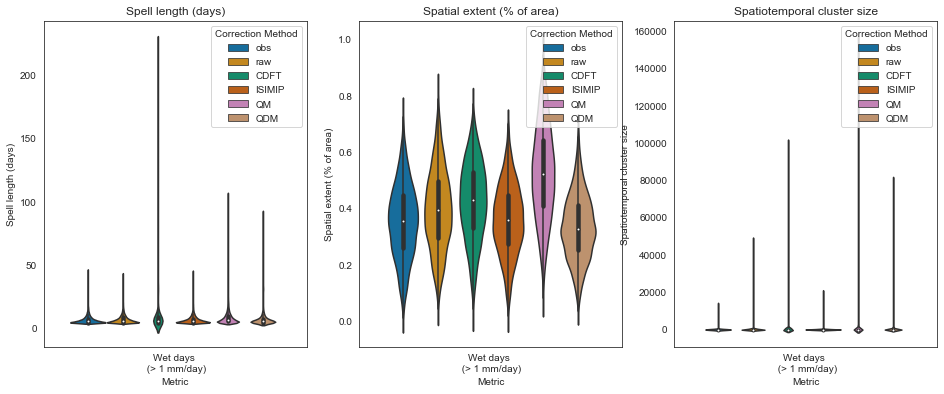

In [49]:
wet_days.violinplots_clusters(minimum_length = 4, obs = pr_obs_validate,
                              raw = pr_cm_validate, CDFT = pr_val_debiased_CDFT,
                              ISIMIP = pr_val_debiased_ISIMIP,
                              QM = pr_val_debiased_QM,
                              QDM = pr_val_debiased_QDM)

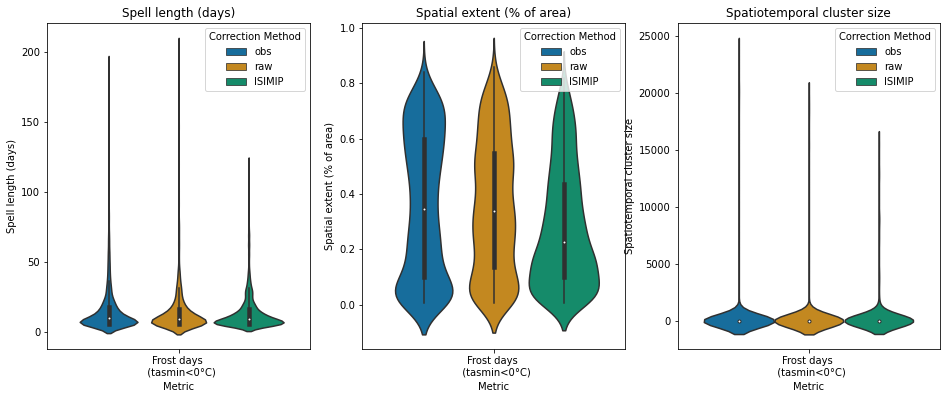

In [35]:
frost_days.violinplots_clusters(minimum_length = 4, obs = tasmin_obs_validate,
                              raw = tasmin_cm_validate,
                              ISIMIP = tasmin_val_debiased_ISIMIP)

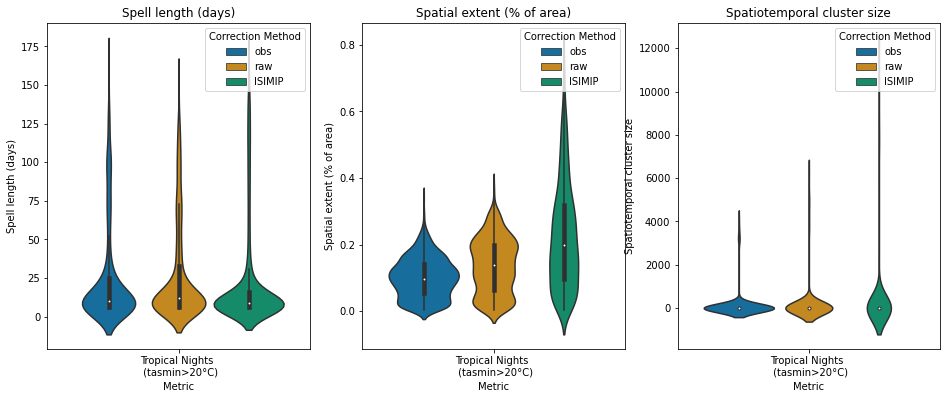

In [36]:
tropical_nights.violinplots_clusters(minimum_length = 4, obs = tasmin_obs_validate,
                              raw = tasmin_cm_validate,
                              ISIMIP = tasmin_val_debiased_ISIMIP)

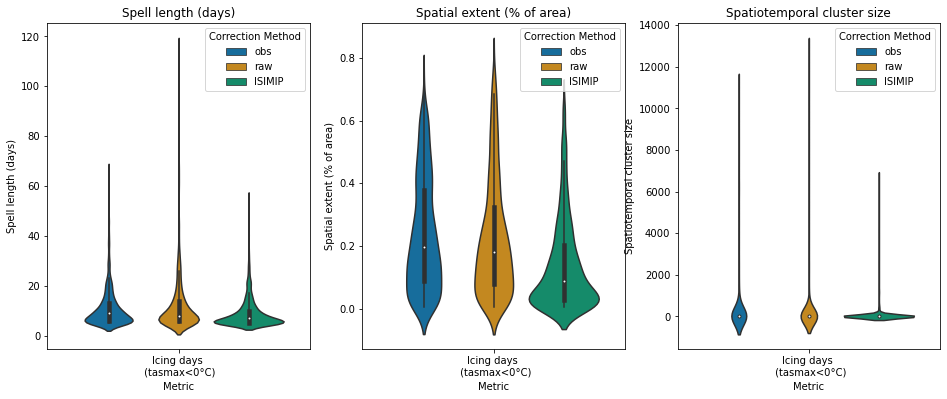

In [37]:
icing_days.violinplots_clusters(minimum_length = 4, obs = tasmax_obs_validate,
                              raw = tasmax_cm_validate,
                              ISIMIP = tasmax_val_debiased_ISIMIP)

We see that bias correction can significantly modify the spatiotemporal extent of threshold metrics. Depending on the application case and context, individual spatiotemporal extent metrics can and should be investigated in more detail, focusing for example on a location-wise bias.

We can now look at the spatial correlation within the entire dataset in different variables. The metric chosen here, calculating the root-mean standard deviation, is slightly unconventional. At each location, the RMSE between the correlation matrix of this location with all others in the observational data, and the correlation matrix in the climate model data is calculated and output in the following map as a single number at each location.

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_58658/3095416973.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_rmsd_spatial_plot.show()


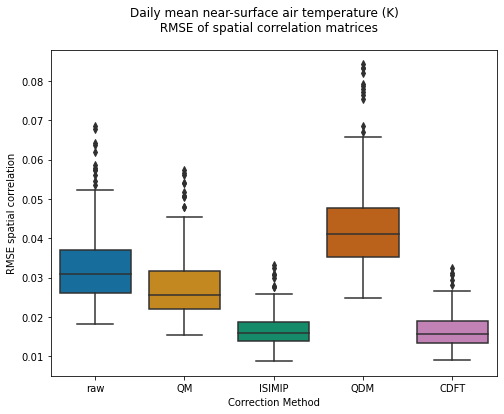

In [38]:
tas_rmsd_spatial = correlation.rmse_spatial_correlation_distribution(variable = 'tas', 
                                                                     obs_data = tas_obs_validate, raw = tas_cm_future,
                                                                     CDFT = tas_val_debiased_CDFT,
                                                                     ISIMIP = tas_val_debiased_ISIMIP,
                                                                     QM = tas_val_debiased_QM, 
                                                                     QDM = tas_val_debiased_QDM
                                                                     )
tas_rmsd_spatial_plot = correlation.rmse_spatial_correlation_boxplot(variable = 'tas', dataset = tas_rmsd_spatial)
tas_rmsd_spatial_plot.show()

We see that ISIMIP and CDFt have the lowest bias in the spatial correlation structure with respect to tas - QM barely improves the bias of the raw climate model, and QDM actually seems to increase it.

### Multivariate structure

This section is currently in an experimental phase and will be expanded upon in the next releases. Nevertheless, we briefly guide you through the analysis that is currently possible.

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2674: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


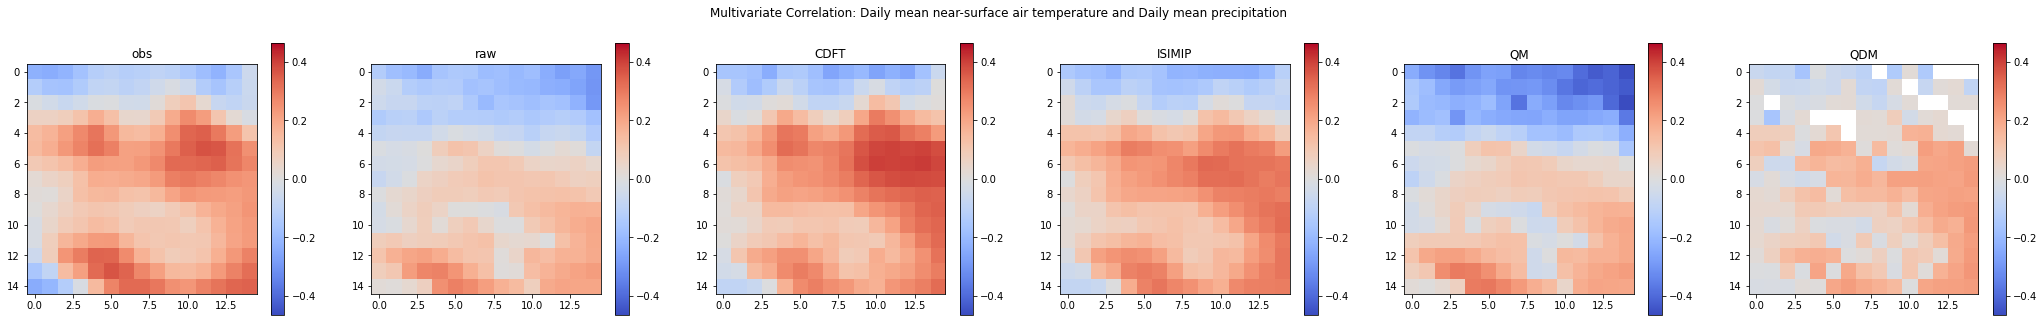

In [39]:
tas_pr_corr = multivariate.calculate_and_spatialplot_multivariate_correlation(variables = ['tas', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], CDFT = [tas_val_debiased_CDFT, pr_val_debiased_CDFT],
                                                               ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP],
                                                               QM = [tas_val_debiased_QM, pr_val_debiased_QM],
                                                                QDM = [tas_val_debiased_QDM, pr_val_debiased_QDM])
plt.show()

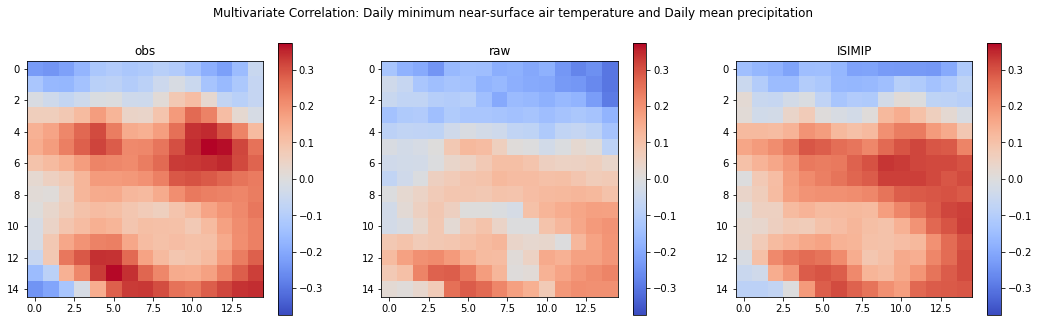

In [40]:
tasmin_pr_corr = multivariate.calculate_and_spatialplot_multivariate_correlation(variables = ['tasmin', 'pr'], obs = [tas_obs_validate, pr_obs_validate], 
                         raw = [tas_cm_validate, pr_cm_validate], ISIMIP = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP])
plt.show()

We see that whereas CDFt, and also to a certain degree ISIMIP, reproduce the structure between tas and pr, Quantile Mapping and Quantile Delta Mapping perform a lot less well. If the relationship between temperature and precipitation is import for the impact study chosen, such as for example investigating frost days that are also wet, CDFt and ISIMIP seem to be preferable in this testing scenario.

In an experimental component of the multivatiate evaluation, we can also plot the two variables as well as their correlation with each other at a single location:

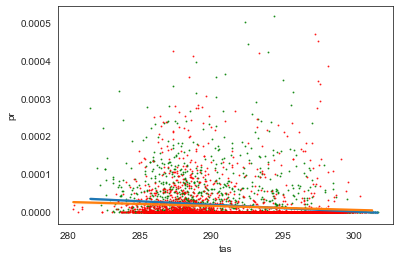

In [41]:
tas_pr_obs, tas_pr_isimip = multivariate.create_multivariate_dataframes(variables = ['tas', 'pr'], datasets_obs = [tas_obs_validate, pr_obs_validate], 
                                                            datasets_bc = [tas_val_debiased_ISIMIP, pr_val_debiased_ISIMIP], gridpoint = (1,1))

tas_pr_corr_11 = multivariate.plot_correlation_single_location(variables = ['tas', 'pr'], obs_df = tas_pr_obs, bc_df = tas_pr_isimip)

We see that a linear approximation does not fit the inter-variable structure too well.

In another experimental component, we can also use bootstrapping to obtain a distribution of estimates of the correlation:

KstestResult(statistic=0.912, pvalue=1.0657876044847793e-222)


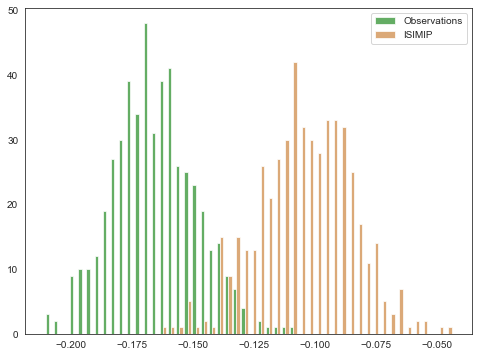

In [42]:
tas_pr_corr_bs = multivariate.plot_bootstrap_correlation_replicates(obs_df = tas_pr_obs, bc_df = tas_pr_isimip,
                                                                    bc_name = 'ISIMIP', size = 500)

We see that the two distributions clearly are not draws from a common distribution, as also indicated by the result of the ks test.

**Conditional joint threshold exceedance of threshold metrics**

To investigate the compounding of different threshold metrics directly, we can calculate their conditional joint threshold exceedance. This is calculated using the following equation:

$$ p (\text{Metric1} | \text{Metric2}) = \frac {p(\text{Metric1} , \text{Metric2})}{p(\text{Metric2})} $$

In this example, we calculate the probability of wet days, given that these days are also frost days. The boxplot shows the distribution of conditional exceedance probability across locations.

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/multivariate.py:36: RuntimeWarning: invalid value encountered in true_divide
  chi = np.einsum("ijk -> jk", cooccurrence) / np.einsum("ijk -> jk", metric2_instances)


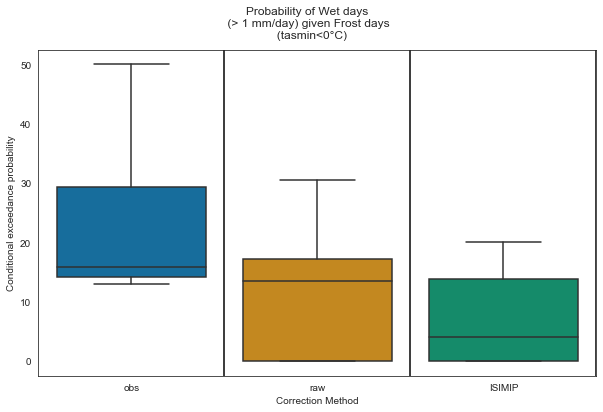

In [43]:
frost_wet = multivariate.calculate_conditional_joint_threshold_exceedance(wet_days, frost_days,
                                                             obs = [pr_obs_validate, tasmin_obs_validate], 
                                                             raw = [pr_cm_validate, tasmin_cm_validate],
                                                            ISIMIP = [pr_val_debiased_ISIMIP, tasmin_val_debiased_ISIMIP])

frost_wet_plot = multivariate.plot_conditional_joint_threshold_exceedance(frost_wet)
plt.show()

We see that in the raw climate model, there are a number of locations where the probability of a compound frost and wet event is lower than in observations. This probability of co-occurrence is further reduced after applying ISIMIP. 

## Part 3: Evaluation of trend preservation


This last section investigates whether the chosen bias correction method modify the trend in the climate model between the validation and the future period. The following steps are conducted in the calculation:
- First, the trend in the chosen statistic (for example the mean) between the validation period and the future period in the *raw* climate model is calculated. 
- Then, the same calculation is performed for the debiased models of interest
- Finally the percentage difference between these two trends is calculated.

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/trend.py:107: RuntimeWarning: divide by zero encountered in true_divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/trend.py:107: RuntimeWarning: invalid value encountered in true_divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend


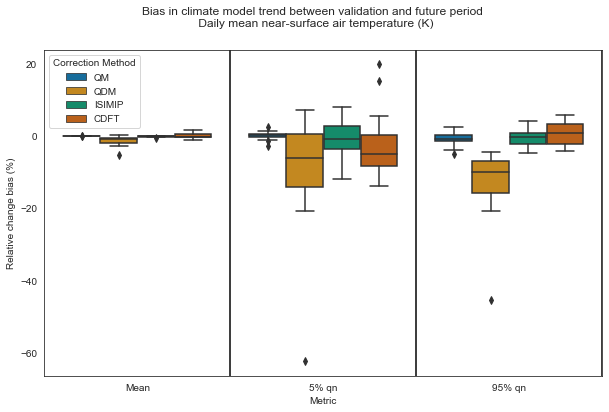

In [44]:
tas_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tas', 
                                                        remove_outliers = True,
                                                  raw_validate = tas_cm_validate, raw_future = tas_cm_future,
                                                        metrics = tas_metrics,
                                                  QM = [tas_val_debiased_QM, tas_fut_debiased_QM],
                                                        QDM = [tas_val_debiased_QM, tas_fut_debiased_QDM],
                                                  ISIMIP = [tas_val_debiased_ISIMIP, tas_fut_debiased_ISIMIP],
                                                  CDFT = [tas_val_debiased_CDFT, tas_fut_debiased_CDFT])




tas_trend_plot = trend.plot_future_trend_bias_boxplot(variable ='tas', bias_df = tas_trend_bias_data)
plt.show()

Wee see that while the trend in mean and 95th percentile is decently preserved in delta-QM, ISIMIP and CDFt, it is modified more in the Quantile Delta Mapping method.

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/trend.py:107: RuntimeWarning: divide by zero encountered in true_divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/trend.py:107: RuntimeWarning: invalid value encountered in true_divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend


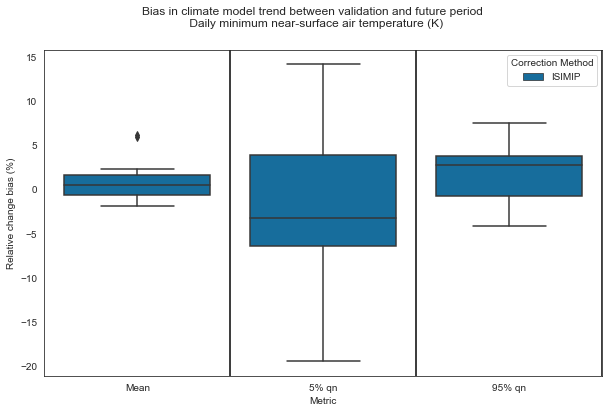

In [45]:
tasmin_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tasmin', 
                                                        remove_outliers = True,
                                                  raw_validate = tasmin_cm_validate, raw_future = tasmin_cm_future,
                                                        metrics = tasmin_metrics,
                                                  ISIMIP = [tasmin_val_debiased_ISIMIP, tasmin_fut_debiased_ISIMIP])




tasmin_trend_plot = trend.plot_future_trend_bias_boxplot(variable ='tasmin', bias_df = tasmin_trend_bias_data)
plt.show()

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/trend.py:107: RuntimeWarning: divide by zero encountered in true_divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend
/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/ibicus/evaluate/trend.py:107: RuntimeWarning: invalid value encountered in true_divide
  trend_bias = 100 * (bc_trend - raw_trend) / raw_trend


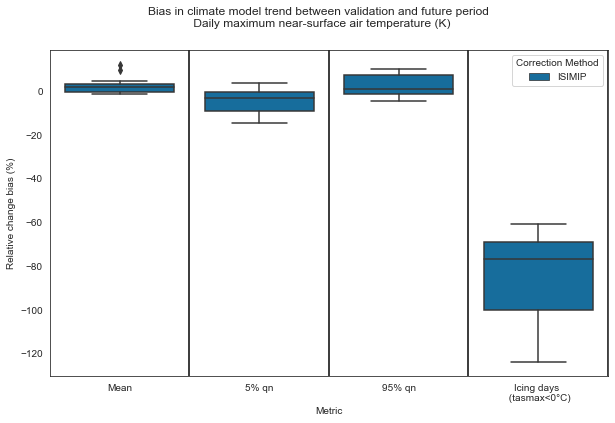

In [46]:
tasmax_trend_bias_data = trend.calculate_future_trend_bias(variable = 'tasmax', 
                                                        remove_outliers = True,
                                                  raw_validate = tasmax_cm_validate, raw_future = tasmax_cm_future,
                                                        metrics = tasmax_metrics,
                                                  ISIMIP = [tasmax_val_debiased_ISIMIP, tasmax_fut_debiased_ISIMIP])




tasmax_trend_plot = trend.plot_future_trend_bias_boxplot(variable ='tasmax', bias_df = tasmax_trend_bias_data)
plt.show()

**Conclusion**: Overall we see that CDF-t, ISIMIP and Quantile Mapping perform decently well when it comes to trend-preservation. Quantile Delta Mapping less so. However, each of these debiasers still introduces trend modifications in certaint variables, such as icing days. This evaluation should therefore be tailored to the impact study at hand.

## Conclusion

This notebook gives a broad overview of the different types of evaluation metrics that can be applied as part of ibicus. For the variables and region studied, ISIMIP and CDFt perform best across metrics, although the choice of debiaser for a specific case-study will depend on the metrics the user is most interested in, as well as an understanding of the source of the climate model bias for the variable of interest.

We hope this notebook provides helpful guidance for you to evaluate your own bias correction project and choose the methodology most suited to your application.